## Примеры форматов для хранения разреженных матриц

In [11]:
%matplotlib inline
from scipy import sparse
from matplotlib import pyplot as plt
import numpy as np

N = 1000
# Создаётся в координатном формате
A = sparse.rand(N, N, 1e-3)
print(type(A))
print('nnz = ', A.nnz)
print(A.data[0:4])
print(A.row[0:4])
print(A.col[0:4])

<class 'scipy.sparse.coo.coo_matrix'>
nnz =  1000
[0.43357887 0.75906904 0.71024671 0.1281996 ]
[356 192 908 532]
[ 98 377 654  35]


Структура разреженности

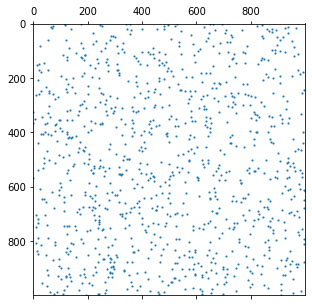

In [12]:
fig, ax = plt.subplots(figsize = (5,5))
ax.spy(A,ms = 1)
x = np.random.rand(1000)
b = A.dot(x)

## Применение быстрого преобразования Фурье


(88200, 2)


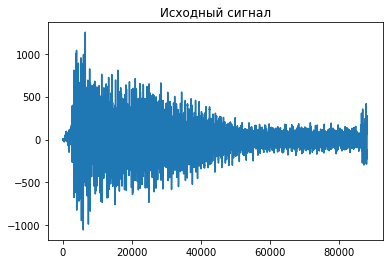

Text(0.5, 1.0, 'График в частотной области')

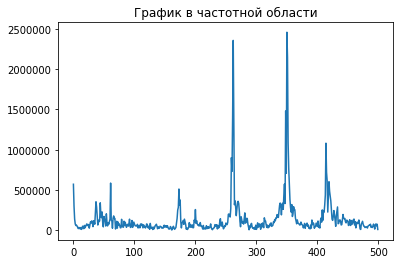

In [19]:
%matplotlib inline
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt

fs, data = wavfile.read('Rakhmaninov.wav')
print(data.shape)
plt.plot(data[:,0])
plt.title('Исходный сигнал')
plt.show()
ft = np.fft.fft(data[:,0])

plt.plot(np.abs(ft[0:500]))
plt.title('График в частотной области')

## Прикладной пример: бисекция графа

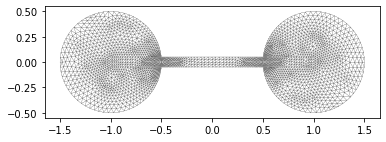

In [20]:
# For barbellgraph from MATLAB
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spsla
import matplotlib as mpl
from matplotlib import collections  as mc


# read file with Laplacian matrix of graph; L = D - A
N = 2713
ii, jj, val = np.loadtxt('barbellgraph_adj.txt', dtype = 'int, int, float',unpack = True)
NNZ = ii.size
# Note " - 1" in indices: this is due to indices in file start from 1
ii = ii - 1
jj = jj - 1

# read file with (x,y) of each vertex
x, y = np.loadtxt('barbellgraph_xy.txt', unpack = True)

# plot graph
lines = []
for k in range(NNZ):
    lines.append([(x[ii[k]], y[ii[k]]), (x[jj[k]], y[jj[k]])])
lc = mc.LineCollection(lines, colors = 'k', linewidths = 0.1)
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_aspect('equal')
plt.savefig('barbellgraph.png', bbox_inches='tight', dpi = 150, format = 'png')


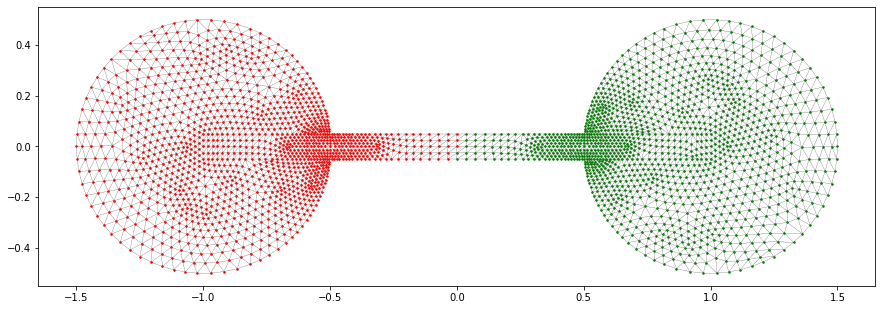

In [15]:
# plot graph
lines = []
for k in range(NNZ):
    lines.append([(x[ii[k]], y[ii[k]]), (x[jj[k]], y[jj[k]])])
lc = mc.LineCollection(lines, colors = 'k', linewidths = 0.1)
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set_aspect('equal')
plt.savefig('barbellgraph.png', bbox_inches='tight', dpi = 150, format = 'png')
# Slow variant: try for comparison
# for k in range(0, np.size(ii)):
#     plt.plot([x[ii[k]], x[jj[k]]], [y[ii[k]], y[jj[k]]], 'b-', 'linewidth', 0.3)

# Create sparse Laplacian matrix
L = sps.coo_matrix((val, (ii,jj)), shape = (N, N))

# find 2 smallest eigenvalues and corresponding vectors
w, v = spsla.eigs(L, k = 2, which ='SM') 

U = v[:,1]
m = np.median(U)
ii1 = np.argwhere(U <= m)
ii2 = np.argwhere(U > m)
part = np.zeros(NNZ, dtype = 'int')
for k in range(ii1.size):
    part[ii1[k]] = 0

for k in range(ii2.size):
    part[ii2[k]] = 1

# plot partition
xx = []
yy = []
for k in range(ii1.size):
    xx.append(x[ii1[k]])
    yy.append(y[ii1[k]])
plt.plot(xx, yy, 'r.', ms = 3)

xx = []
yy = []
for k in range(ii2.size):
    xx.append(x[ii2[k]])
    yy.append(y[ii2[k]])
plt.plot(xx, yy, 'g.', ms = 3)

# plt.savefig('figures/spectral_partition.png', bbox_inches='tight', dpi = 300, format = 'png')

## Уменьшение ширины ленты
Переупорядочивание уравнений и неизвестных может уменьшить ширину ленты разреженной матрицы, что, в свю очередь, делает возможными применение прямых методов (LU разложение и т.п.)

Ниже создаётся матрица, которая возникает при конечно-разностной аппроксимации уравнения Лапласа $\Delta u(x,y) = 0$.

Сначала используется естественная нумерация неизвестных: $I = (j-1) * n + i$, где $i,j$ - индексы сетки по $x$ и $y$.

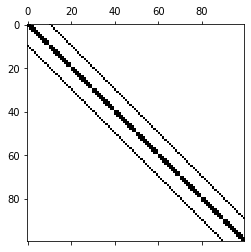

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.sparse as sps

n = 10
A = np.zeros((n**2, n**2), dtype = np.float64)
for i in range(n):
    for j in range(n):
        I = j * n + i # equation number 
        A[I, I] = -4.0
        if (i > 0):
            J = j * n + i - 1
            A[I, J] = 1.0
        if (i < n-1):
            J = j * n + i + 1
            A[I, J] = 1.0
        if (j > 0):
            J = (j - 1) * n + i
            A[I, J] = 1.0
        if (j < n-1):
            J = (j + 1) * n + i
            A[I, J] = 1.0
# print(A)
plt.spy(A)        

Теперь делаем reordering с помощью готовой функции. В итоге лента сужается.

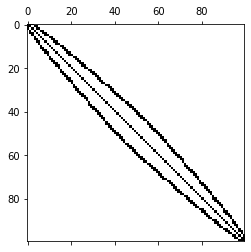

In [24]:
import scipy.sparse.csgraph as csgraph
As = sps.csr_matrix(A)
# Вектор перестановки
p = csgraph.reverse_cuthill_mckee(As)
# print(p)
for i in range(n**2):
    A[:, i] = A[p, i]
for i in range(n**2):
    A[i, :] = A[i, p]
plt.spy(A)